<a href="https://colab.research.google.com/github/sean-halpin/guided_diffusion/blob/main/test_diffusion_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers[training]==0.1.3

In [2]:
from diffusers import DiffusionPipeline, DDPMScheduler

In [3]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from diffusers import DiffusionPipeline
from diffusers import DDPMScheduler, UNet2DConditionModel

class DDPMConditionalPipeline(DiffusionPipeline):
    def __init__(self, unet: UNet2DConditionModel, scheduler):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(unet=unet, scheduler=scheduler)

    @torch.no_grad()
    def __call__(self, guidance_scale, batch_size=1, generator=None, torch_device=None, output_type="pil", hidden_states=None):
        if torch_device is None:
            torch_device = "cuda" if torch.cuda.is_available() else "cpu"

        self.unet.to(torch_device)

        # Sample gaussian noise to begin loop
        latents = torch.randn(
            (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size),
            generator=generator,
        )
        latents = latents.to(torch_device)

        # set step values
        self.scheduler.set_timesteps(1000)

        uncond_input = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).long().repeat(eval_batch_size_,1).to("cuda")
        # uncond_embeddings = (emb(uncond_input))
        uncond_embeddings = nn.functional.pad(input=uncond_input, pad=(0, 1280 - uncond_input.shape[1]), mode='constant', value=0).float().unsqueeze(1)

        for t in tqdm(self.scheduler.timesteps):
            # 1. predict noise noise_pred
            latents_input = torch.cat([latents] * 2)
            context = torch.cat([uncond_embeddings, hidden_states])
            noise_pred = self.unet(latents_input, t, encoder_hidden_states=context)["sample"]

            noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

            # 2. compute previous image: x_t -> t_t-1
            latents = self.scheduler.step(noise_pred, t, latents)["prev_sample"]

        image = (latents / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image}

In [4]:
# dp = DiffusionPipeline.from_pretrained('shalpin87/diffusion_celeba')
# dpc = DiffusionPipeline.from_pretrained('shalpin87/diffusion_cifar')
cond_dp = DDPMConditionalPipeline.from_pretrained('shalpin87/diffusion_conditional')

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/865 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/182M [00:00<?, ?B/s]

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

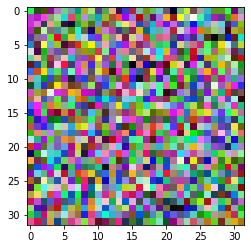

In [6]:
nz = torch.randint(0, 255, (1,3,32,32))
nz.shape
plt.imshow((nz.permute(0,2,3,1)).squeeze(0))
plt.show()

In [7]:
def plot_images(images):
  images_processed = (images * 255).round().astype("uint8")
  imgs_t = images_processed.transpose(0, 3, 1, 2)
  imgs_plt = images_processed.transpose(0, 1, 2, 3)

  fig = plt.figure(figsize=(8, 8))
  columns = 4
  rows = 4
  for i in range(1, columns*rows +1):
      img = imgs_plt[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

In [8]:
import string
import random
def id_generator(size=12, chars=string.ascii_uppercase + string.digits):
  return ''.join(random.choice(chars) for _ in range(size))

In [9]:
from PIL import Image
def save_images(images, path):
  images_processed = (images * 255).round().astype("uint8")
  imgs_t = images_processed.transpose(0, 3, 1, 2)
  imgs_plt = images_processed.transpose(0, 1, 2, 3)
  for i in range(0, len(imgs_plt)):
    img = Image.fromarray(imgs_plt[i])
    id = id_generator()
    img.save(f'{path}/{id}.jpeg')

In [70]:
batch_img_count=64
eval_batch_size_=64

In [12]:
!mkdir -p "./generated_cifar"
!mkdir -p "./generated_celeba"
!mkdir -p "./generated_unseen_celeba"
!mkdir -p "./generated_seen_celeba"

In [ ]:
generator = torch.manual_seed(0)
for i in range(0,16):
  images = dp(generator=generator, batch_size=batch_img_count, output_type="numpy")["sample"]
  plot_images(images)
  save_images(images, "./generated_celeba")

In [ ]:
generator = torch.manual_seed(0)
for i in range(0,16):
  imagesc = dpc(generator=generator, batch_size=batch_img_count, output_type="numpy")["sample"]
  plot_images(imagesc)
  save_images(imagesc, "./generated_cifar")

In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
!nvidia-smi

In [15]:
from torchvision.datasets import CelebA, CIFAR10
from torchvision import transforms

In [16]:
tf = transforms.Compose(
  [
    transforms.Resize((32, 32)),
    transforms.ToTensor()
  ]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!mkdir -p ./dataset_celeba
!rm -rf ./dataset_celeba/*
!cp -R ./drive/MyDrive/celeba/* ./dataset_celeba/celeba
!unzip "./dataset_celeba/celeba/img_align_celeba.zip" -d "./dataset_celeba/celeba"

In [18]:
x_size = 32
y_size = x_size

dataset_cifar = CIFAR10(
  "./dataset_cifar/",
  download=True,
  transform=tf,
)

dataset_celeba = CelebA(
  "./dataset_celeba/",
  download=False,
  transform=tf,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset_cifar/cifar-10-python.tar.gz to ./dataset_cifar/


# Find unseen attributes

In [23]:
s = set()
t = torch.tensor([0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0]).__str__()[7:-1].replace("\n","").replace(" ","")
w = torch.tensor([0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0]).__str__()[7:-1].replace("\n","").replace(" ","")
s.add(t)
s.add(w)
print(s)

{'[0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0]'}


In [31]:
from tqdm import tqdm
seen = dict()
for x,y in tqdm(dataset_celeba):
  seen[(y.__str__()[7:-1].replace("\n","").replace(" ",""))] = y
  # break

100%|██████████| 162770/162770 [03:36<00:00, 753.32it/s]


In [32]:
nextone = next(iter(seen))

In [33]:
if nextone in seen:
  print("Exists")

Exists


In [44]:
for k,v in seen.items():
  print(v)
  break

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])


In [49]:
unseen = dict()
for i in tqdm(range(0,2048)):
  rand_attr = torch.randint(0,2,[1,40])
  r_str = rand_attr.__str__()[7:-1].replace("\n","").replace(" ","")
  if r_str in seen:
    print("already seen")
  else:
    unseen[r_str] = rand_attr

100%|██████████| 2048/2048 [00:00<00:00, 5427.26it/s]


In [50]:
print(len(dataset_celeba))
print(len(seen))
print(len(unseen))

162770
96486
2048


In [63]:
i=0
len(list(unseen.values())[i*batch_img_count:(i*batch_img_count)+batch_img_count])
stack = torch.stack(list(unseen.values())[i*batch_img_count:(i*batch_img_count)+batch_img_count])
stack.shape

torch.Size([128, 1, 40])

torch.Size([64, 1, 1280])


100%|██████████| 1000/1000 [12:02<00:00,  1.38it/s]


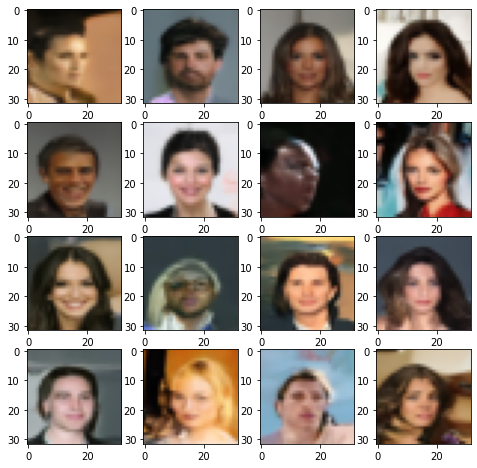

torch.Size([64, 1, 1280])


 94%|█████████▎| 935/1000 [11:15<00:46,  1.38it/s]


RuntimeError: ignored

In [73]:
generator = torch.manual_seed(0)

guidance = 10.0
for i in range(0,int(2048/batch_img_count)):
  attr = torch.stack(list(unseen.values())[i*batch_img_count:(i*batch_img_count)+batch_img_count]).squeeze(1)
  y = nn.functional.pad(input=attr, pad=(0, 1280 - attr.shape[1]), mode='constant', value=0).unsqueeze(1).float()
  print(y.shape)
  imagesc = cond_dp(guidance, generator=generator, batch_size=batch_img_count, output_type="numpy",hidden_states=y.to("cuda"))["sample"]
  plot_images(imagesc)
  save_images(imagesc, "./generated_unseen_celeba")

# Generate Originals

In [ ]:
!mkdir -p './original_celeba'
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset_celeba, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
for batch, _ in (dataloader):
  img = transforms.ToPILImage()(batch[0])
  id = id_generator()
  img.save(f'./original_celeba/{id}.jpeg')
  # break

In [ ]:
!pip install pytorch-fid

In [ ]:
!python -m pytorch_fid "/content/generated_celeba/" "/content/original_celeba/"

In [ ]:
!ls /content/generated_celeba/

In [ ]:
!mkdir -p './original_cifar'

In [ ]:
for x in dataset_cifar:
  id = id_generator()
  x[0].save(f'./original_cifar/{id}.jpeg')

In [ ]:
!python -m pytorch_fid "/content/generated_cifar/" "/content/original_cifar/"

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100% 41/41 [00:07<00:00,  5.40it/s]
100% 1000/1000 [01:41<00:00,  9.89it/s]
FID:  34.396816864008315


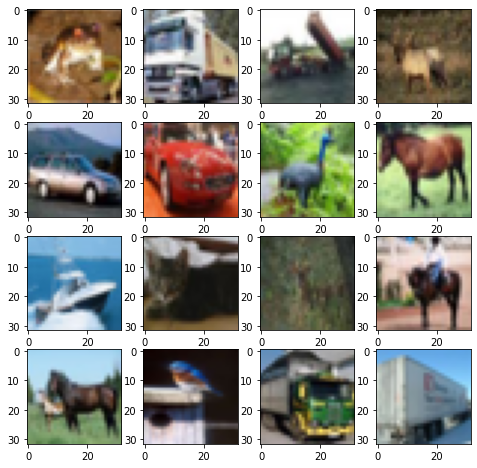

In [ ]:
orig_cfars = []
for x in dataset_cifar:
  orig_cfars.append(x[0])

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = orig_cfars[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

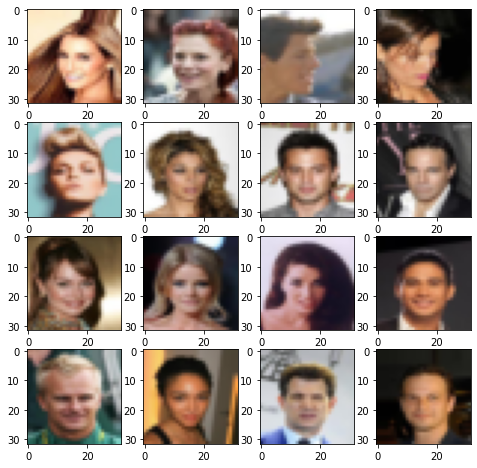

In [ ]:
i = 0
orig_celebas = []
for x in dataset_celeba:
  orig_celebas.append(x[0])
  i += 1
  if i > 20:
    break

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = orig_celebas[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.permute(1, 2, 0))
plt.show()